In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim) -> None:
        super(FNN, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, inputs):
        return self.mlp(inputs)

In [2]:
class HJB():
    def __init__(self, d, T, lemda, sigma, g) -> None:
        self.T = T
        self.lemda = lemda
        self.sigma = sigma
        self.g = g
        self.d = d
    def FSDE(self, x0, batch, N):
        x0 = torch.tensor(x0, dtype=torch.float32)
        delta_t = self.T / N
        delta_Wt = torch.randn([batch, N, self.d]) * torch.sqrt(torch.tensor(delta_t))
        Xt = torch.ones([batch, N+1, self.d])*x0
        for i in range(N):
            Xt[:, i+1] = Xt[:, i] + self.sigma * delta_Wt[:, i]
        return Xt, delta_Wt

In [3]:

import numpy as np
class BSDE(nn.Module):
    def __init__(self, N, d, T, lemda, sigma, g):
        super(BSDE, self).__init__()
        self.N = N
        self.d = d
        self.equation = HJB(d, T, lemda, sigma, g)
        self.NN = nn.ModuleList([FNN(d, d, 100) for _ in range(N)])
        self.result = nn.Parameter(torch.rand(1) + 1, requires_grad=True)

    def forward(self, x0, batch):
        delta_t = self.equation.T / self.N
        Xt, delta_Wt = self.equation.FSDE(x0, batch, self.N)
        u = torch.ones(batch, 1) * self.result
        for i in range(self.N):
            grad_u =  self.NN[i](Xt[:, i])
            grad_u_ = grad_u.unsqueeze(1)
            print(grad_u.shape)

            u = u + self.equation.lemda * (torch.norm(grad_u, dim=1, keepdim=True))**2 * delta_t + self.equation.sigma * torch.bmm(grad_u_, delta_Wt[:, i].unsqueeze(2)).squeeze(1)

        return u, self.equation.g(Xt[:,self.N])


In [8]:
import numpy as np
def g(x):
    return torch.log((1 + (torch.norm(x, dim=1, keepdim=True))**2) / 2)
sigma = np.sqrt(2)
# Instantiate the BSDE
bsde = BSDE(N=20, d=100, T=1.0, lemda=1.0, sigma=sigma, g=g)
epoch = 4000
lr = 0.01
batch = 64
x = torch.zeros([100])
loss_fun = nn.MSELoss()
opt = torch.optim.Adam(bsde.parameters(), lr=lr)
loss_values = torch.zeros(epoch)
relative_errors = []


for i in range(epoch):
    bsde.train()
    opt.zero_grad()
    u, u0 = bsde(x, batch)
    loss = loss_fun(u, u0)
    loss.backward()
    opt.step()
    bsde.eval()
    relative_error = torch.abs((bsde.result.detach() -4.5893) / 4.5893)
    avg_relative_error = torch.mean(relative_error)
    relative_errors.append(avg_relative_error.item())
    loss_values[i] = bsde.result.detach()

    print(f"Iteration: {i}, Loss: {loss_values[i]}, Relative Error: {avg_relative_error.item()}")

C:\Users\Dell\AppData\Local\Temp\ipykernel_12836\2896377562.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32)


Iteration: 0, Loss: 1.9275670051574707, Relative Error: 0.5799867510795593
Iteration: 1, Loss: 1.9175561666488647, Relative Error: 0.5821680426597595
Iteration: 2, Loss: 1.9075218439102173, Relative Error: 0.5843545794487
Iteration: 3, Loss: 1.8974556922912598, Relative Error: 0.5865479111671448
Iteration: 4, Loss: 1.8873803615570068, Relative Error: 0.5887433290481567
Iteration: 5, Loss: 1.877265214920044, Relative Error: 0.5909473896026611
Iteration: 6, Loss: 1.8671401739120483, Relative Error: 0.5931535959243774
Iteration: 7, Loss: 1.8570847511291504, Relative Error: 0.5953446626663208
Iteration: 8, Loss: 1.847074270248413, Relative Error: 0.597525954246521
Iteration: 9, Loss: 1.8371614217758179, Relative Error: 0.5996859073638916
Iteration: 10, Loss: 1.8272441625595093, Relative Error: 0.6018468737602234
Iteration: 11, Loss: 1.8173445463180542, Relative Error: 0.6040039658546448
Iteration: 12, Loss: 1.8075202703475952, Relative Error: 0.6061446666717529
Iteration: 13, Loss: 1.79773

<function matplotlib.pyplot.show(close=None, block=None)>

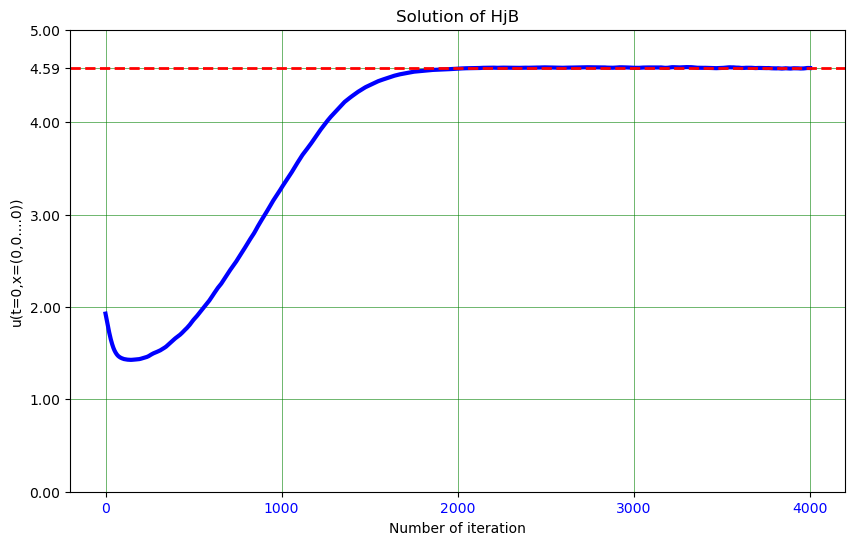

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(range(4000), loss_values, color='blue', lw=3, label='Approximated solution')
plt.axhline(y=4.5893, color='red', lw=2, linestyle='--', label='True Solution ')
plt.xlabel("Number of iteration")
plt.ylabel("u(t=0,x=(0,0....0))")
plt.title("Solution of HjB")
plt.yticks(np.append(np.arange(0,5.5,1),4.5893))
plt.xticks(np.arange(0,4500,1000),color="blue")
plt.grid(color='green',lw=0.4)
plt.show


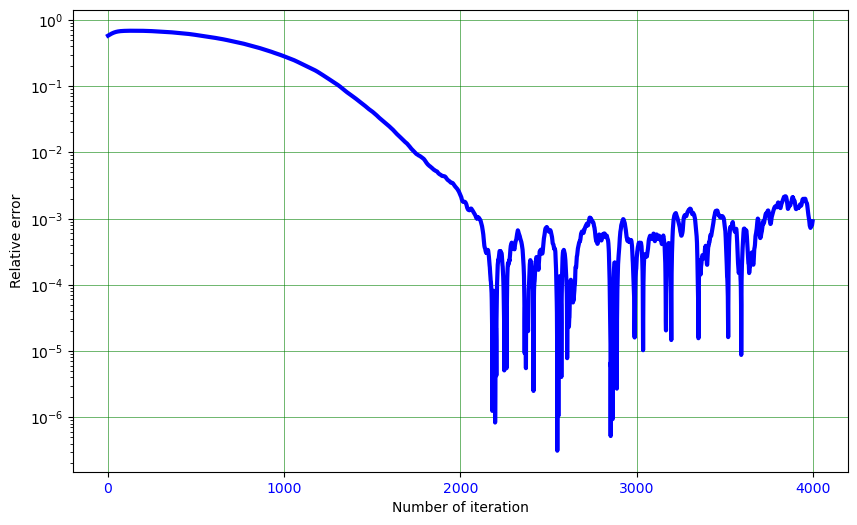

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(relative_errors   , color='blue', lw=3)


plt.xlabel("Number of iteration")
plt.ylabel("Relative error")
plt.xticks(np.arange(0,4500,1000),color="blue")
plt.yscale('log')
plt.grid(color='green',lw=0.4)
plt.show()

In [16]:
def train_bsde_model(bsde, epoch, lr, batch_size):
    x = torch.zeros([100])
    loss_fun = nn.MSELoss()
    opt = torch.optim.Adam(bsde.parameters(), lr=lr)
    loss_values = torch.zeros(epoch)

    for i in range(epoch):
        bsde.train()
        opt.zero_grad()
        u, u0 = bsde(x, batch_size)
        loss = loss_fun(u, u0)
        loss.backward()
        opt.step()

        bsde.eval()
        loss_values[i] = bsde.result.detach()

    return loss_values

In [17]:
import numpy as np

num_runs = 5
results = []

for run in range(num_runs):
    
    bsde = BSDE(N=20, d=100, T=1.0, lemda=1.0, sigma=sigma, g=g)
    epoch = 4000
    lr = 0.01
    batch = 64
    x = torch.zeros([100])
    loss_values = train_bsde_model(bsde, epoch, lr, batch)
    results.append(loss_values)

results = torch.stack(results)

C:\Users\Dell\AppData\Local\Temp\ipykernel_12836\2896377562.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(x0, dtype=torch.float32)


In [20]:
rel_res =4.5893
relative_error = torch.log10(torch.abs(results-rel_res)/rel_res)
mean_loss = torch.mean(relative_error,dim=0)
std_dev_loss = torch.sqrt(torch.mean((relative_error-mean_loss.unsqueeze(0))**2,dim=0))

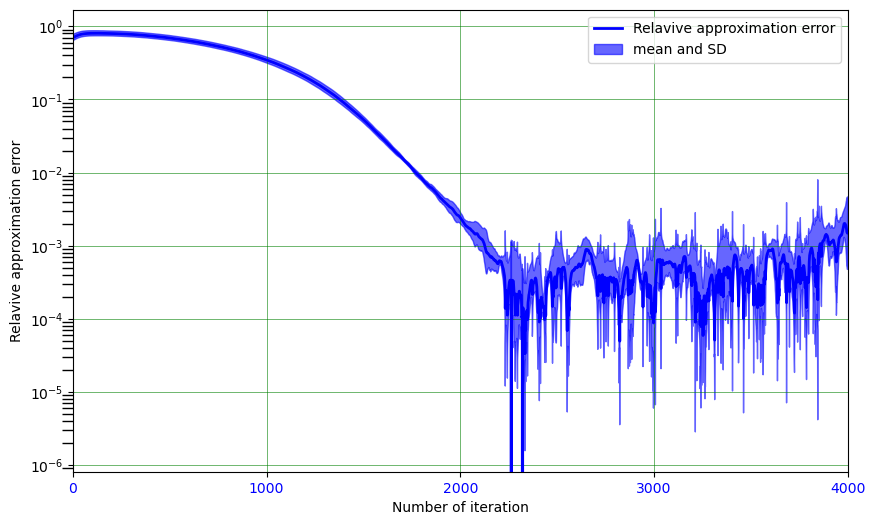

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# Plot mean and standard deviation
plt.figure(figsize=(10, 6))
plt.plot(10**(mean_loss), color='blue', lw=2, label="Relavive approximation error")
plt.fill_between(range(epoch), 10**( mean_loss - std_dev_loss), 10**(mean_loss + std_dev_loss),color='blue', alpha=0.6, label="mean and SD ")
plt.xlabel("Number of iteration")
plt.ylabel("Relavive approximation error")
plt.legend()
plt.xlim([0,2000])
plt.yscale('log')
plt.grid(color='green',lw=0.4)

plt.xticks(np.arange(0,4500,1000),color="blue")



plt.tick_params(axis="y", which="minor", length=8, width='1')


plt.show()

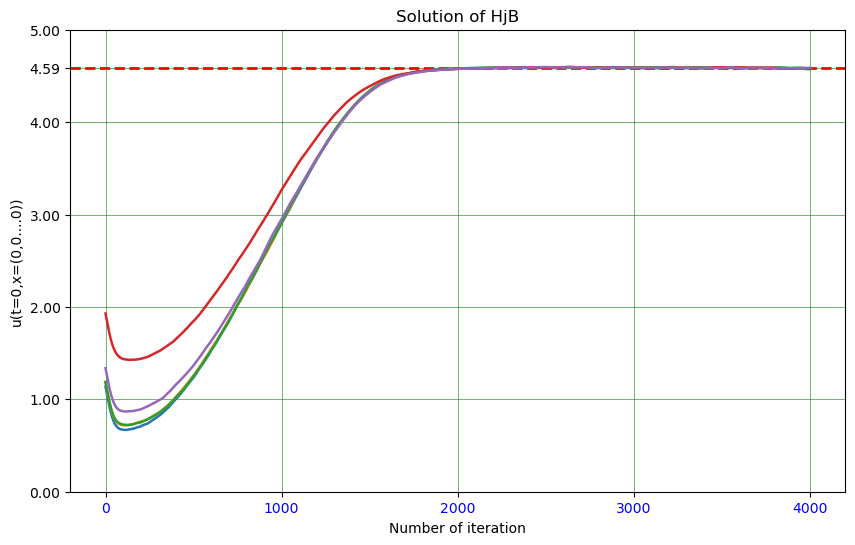

In [26]:
import matplotlib.pyplot as plt

# Plot relative errors
plt.figure(figsize=(10, 6))
plt.axhline(y=4.5893, color='red', lw=2, linestyle='--', label='True Solution ')
for Experments in range(num_runs):
    plt.plot(results[Experments], label=f"Experments{Experments+1}", lw=1.8)
plt.xlabel("Number of iteration")
plt.ylabel("u(t=0,x=(0,0....0))")
plt.title("Solution of HjB")
plt.yticks(np.append(np.arange(0,5.5,1),4.5893))
plt.xticks(np.arange(0,4500,1000),color="blue")
plt.grid(color='green',lw=0.4)

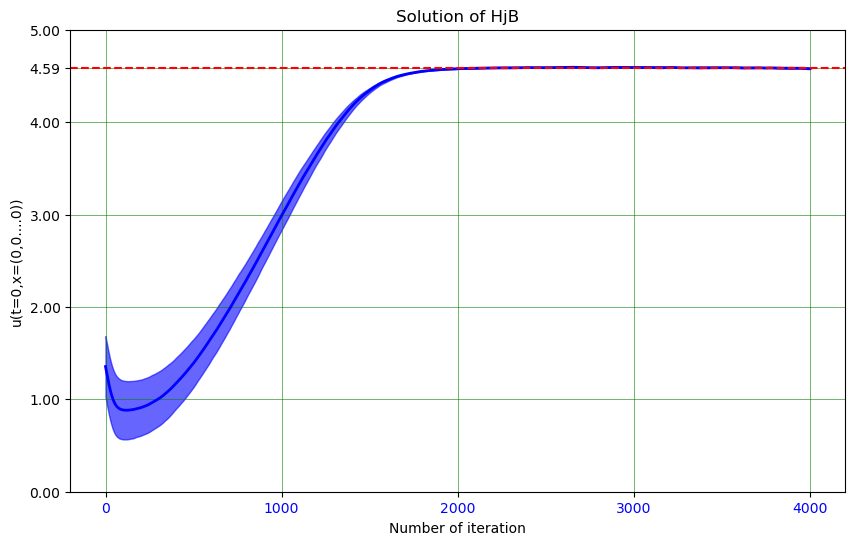

In [29]:
mean_loss = results.mean(dim=0)
std_loss = results.std(dim=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(mean_loss.numpy(), lw=2, color='blue',label=r' Apprximated solution')
plt.axhline(y=4.5893, color='red', lw=1.5, linestyle='--', label='True Solution ')
plt.fill_between(range(epoch), (mean_loss - std_loss).numpy(), (mean_loss + std_loss).numpy(), color='blue', alpha=0.6)
plt.xlabel("Number of iteration")
plt.ylabel("u(t=0,x=(0,0....0))")
plt.title("Solution of HjB")
plt.yticks(np.append(np.arange(0,5.5,1),4.5893))
plt.xticks(np.arange(0,4500,1000),color="blue")
plt.grid(color='green',lw=0.4)